# African Credit Score Prediction Challenge


## Prompt:
Financial institutions need to predict loan defaults to mitigate risk and optimise lending decisions. In Africa’s rapidly growing financial markets, with diverse customer demographics and dynamic economic conditions, accurately assessing default risk is more important than ever.

In this challenge, we want you to develop a robust, generalisable machine learning model to `predict the likelihood of loan defaults for both existing customers and new applicants.` Beyond accurate predictions, `we encourage yous to innovate by incorporating unique factors relevant to each financial market`.

The objective of this challenge is to develop a machine learning model that accurately `predicts the probability of loan default.`

The top 10 winners, in addition to submitting their solution, `will need to design and submit a credit scoring function, using their model's outputs and probabilities. This step involves binning model outputs into risk categories and proposing a scalable credit risk score.`

By accurately predicting loan defaults, your work will enable the client organisation to create a credit scoring solution to evaluate risk more effectively, improving decision-making, reducing financial losses associated with high-risk lending, and allowing for expansion into new financial markets.
The challenge provider is a private asset manager that operates in several financial markets across Africa.


### Points
- Predict likelihoold of loan default for new and existing applicants
- Incorporate unique factors relevant to each financial market (**Kenya and Ghana ??**)
- Credit scoring function (**probability of default**)
- Kenya (train and test set) and Ghana (test set)

## About Data

You will work with loan and customer data from Kenya (train and test set) and Ghana (test set). This split emphasises the need for models that generalise well, i.e. perform well across different countries and financial contexts.

You will notice that a customer ID can appear in multiple rows of the dataset, and for a given customer, a loan ID can also appear with different lender IDs. For example, we can have the same customer ID on three rows with the same loan ID on each but a different lender ID. This observation means that the loan is funded by three separate lenders.

Additional data pulled from the Federal Reserve Economic Data (FRED) portal are provided to enrich model performance and offer insights into features that impact on credit scoring.

The economic indicators are:

FP.CPI.TOTL.ZG: Inflation, consumer prices (annual %)<br/>
PA.NUS.FCRF: Official exchange rate (LCU per US$, period average) <br/>
FR.INR.RINR: Real interest rate (%)<br/>
AG.LND.PRCP.MM: Average precipitation in depth (mm per year)<br/>
FR.INR.DPST: Deposit interest rate (%)<br/>
FP.INR.LEND: Lending interest rate (%)<br/>
FR.INR.LNDP: Interest rate spread (lending rate minus deposit rate, %<br/>
EG.USE.COMM.FO.ZS: Fossil fuel energy consumption (% of total)<br/>
SL.UEM.TOTL.ZS: Unemployment rate

The data downloaded from FRED is saved in a separate CSV in the data section.

## Description of variables in Train/Test.csv

0. **ID**: A unique identifier for each entry in the dataset.

1. **customer_id**: Unique identifier for each customer in the dataset.

2. **country_id**: Identifier or code representing the `country where the customer resides or where the loan was issued`.

3. **tbl_loan_id**: Unique identifier for each loan associated with the customer.

4. **Total_Amount**: The total loan amount initially disbursed to the customer.

5. **Total_Amount_to_Repay**: The total amount the customer is expected to repay, including principal, interest, and fees.

6. **loan_type**: The category or type of loan.

7. **disbursement_date**: The date when the loan amount was disbursed to the customer.

8. **duration**: The length of the loan term, typically expressed in days

9. **lender_id**: Unique identifier for the lender or institution that issued the loan.

10. **New_versus_Repeat**: Indicates whether the loan is the customer's first loan ("New") or if the customer has taken loans before ("Repeat").

11. **Amount_Funded_By_Lender**: The portion of the loan funded directly by the lender.

12. **Lender_portion_Funded**: Percentage of the total loan amount funded by the lender.

13. **due_date**: The date by which the loan repayment is due.

14. **Lender_portion_to_be_repaid**: The portion of the outstanding loan that needs to be repaid to the lender.

15. **target**: This variables takes the value 0 or 1. 1 means the customer defaulted on the loan, whereas 0 means, the customer paid the loan.

### Points:
- Customer data from `Kenya (train and test set)` and Ghana `(test set)`
- We can have the same customer ID on three rows with the same loan ID on each but a different lender ID.
- Additional data pulled from the Federal Reserve Economic Data (FRED) portal

### Possible New Features
- Number of lenders per loan
- Number of loans ✅
- You are welcome to enrich the dataset with economic data sourced from the Federal Reserve Bank on the countries of interest.
- Interest (Total_Amount_to_Repay - Total_Amount) ✅
- Interest rate (Total_Amount_to_Repay - Total_Amount)/Total_Amount ✅
- Lender popularity (frequency of given **lender_id** in data)

## Global Constants

In [1]:
import os

In [2]:
DATA_PATH = "../data"
TRAIN_PATH = os.path.join(DATA_PATH, "Train.csv")
TEST_PATH = os.path.join(DATA_PATH, "Test.csv")
ECONOMIC_INDICATORS_PATH = os.path.join(DATA_PATH, "economic_indicators.csv")
SAMPLE_SUB_PATH = os.path.join(DATA_PATH, "SampleSubmission.csv")
SUBMISSION_PATH = "../submissions/"

# Inspection
Familiarizing with submission data

In [3]:
## imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats

### Sample Submission

##### NOTES:
- Entries within submission are not unique to applicants (i.e. multiple entries can have the same customer_id)

In [4]:
sample_submission_df = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission_df.head()

,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [5]:
print("Number of entries:", sample_submission_df.shape[0])
print("Number of unique applicants", len(sample_submission_df.ID.unique()))

Number of entries: 18594
Number of unique applicants 18594


### Test Data

##### Notes:
- Test set reveals that prediction is done per entry and not per customer.

In [6]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


In [7]:
print("Number of entries:", test_df.shape[0])
print("Number of unique applicants", len(test_df.customer_id.unique()))

Number of entries: 18594
Number of unique applicants 4962


### Economic Indicators

In [8]:
economic_indicators_df = pd.read_csv(ECONOMIC_INDICATORS_PATH)
economic_indicators_df.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


### Train Data

In [9]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [10]:
print("Number of entries:", train_df.shape[0])
print("Number of unique applicants", len(train_df.customer_id.unique()))

Number of entries: 68654
Number of unique applicants 6540


#### Checking for nulls

In [11]:
train_df.isna().sum()

ID                             0
customer_id                    0
country_id                     0
tbl_loan_id                    0
lender_id                      0
loan_type                      0
Total_Amount                   0
Total_Amount_to_Repay          0
disbursement_date              0
due_date                       0
duration                       0
New_versus_Repeat              0
Amount_Funded_By_Lender        0
Lender_portion_Funded          0
Lender_portion_to_be_repaid    0
target                         0
dtype: int64

## Exploratory Data Analysis

- Check if an applicant can default on just some of all their loans ✅
- Check balance of target ✅
- Check the number of unique lenders ✅
- Check the number of loan types ✅
- Check distribution of New vs Repeat
- Percentages (e.g. % amount funded by lender and so on.)
- Compare date with economic indicators
- Look into `duration` seems 7 occurs a lot
- correlation between features

#### Checking if an applicant can on only some of their loans

If an applicant who defaulted has their id recurring in a non-default then they can default on particular loans.
<br/>
Steps:
- Get all applicants who defaulted
- Get all applicants who didn't default
- Add number (if number > total number of applicantes, then statment proven)

#### Notes
- An applicant can default on just `some` loans

In [12]:
## getting all defaulted applicantes
num_default = len(train_df.query("target==1")["customer_id"].unique())
num_not_default = len(train_df.query("target==0")["customer_id"].unique())

print(f"Defaulted Applicants: {num_default} ")
print(f"Non-Defaultant Applicants: {num_not_default}")
print(f"Total:", num_default + num_not_default)
print(f"Total applicants:", len(train_df["customer_id"].unique()))

Defaulted Applicants: 1016 
Non-Defaultant Applicants: 6158
Total: 7174
Total applicants: 6540


#### Checking if there are duplicate loans

If there are duplicate loans, then some loan ids would have been repeated in the dataset

##### Notes
- There are <span style="color: red">repeated loans</span>

In [13]:
len(train_df["tbl_loan_id"].unique()) == len(train_df)

False

#### Checking number of unique lenders

There are `4` unique lenders

In [14]:
train_df["lender_id"].value_counts()

lender_id
267278    64653
251804     3542
267277      271
245684      188
Name: count, dtype: int64

In [15]:
print(f"Number of unique lenders {train_df['lender_id'].nunique()}")

Number of unique lenders 4


#### Checking number of loan types

There are `22` loan types

In [16]:
train_df["loan_type"].unique()

array(['Type_1', 'Type_7', 'Type_5', 'Type_4', 'Type_6', 'Type_14',
       'Type_9', 'Type_10', 'Type_19', 'Type_16', 'Type_2', 'Type_11',
       'Type_23', 'Type_18', 'Type_17', 'Type_12', 'Type_20', 'Type_13',
       'Type_21', 'Type_15', 'Type_24', 'Type_22'], dtype=object)

In [17]:
print(f"There are {train_df.loan_type.nunique()}")

There are 22


### Univariate Analysis

Look into:
- lender_id (frequency)
- loan_type (frequency)

#### ID

In [18]:
train_df["ID"].head()

0    ID_266671248032267278
1    ID_248919228515267278
2    ID_308486370501251804
3    ID_266004285009267278
4    ID_253803305312267278
Name: ID, dtype: object

###### Checking for duplicates

###### Notes
- There are no duplicate entries

In [19]:
len(train_df["ID"].unique()) == len(train_df)

True

### Multivariate Analysis

#### Pairplot

In [20]:
pairplot_df = train_df[:]
pairplot_df["country_id"] = LabelEncoder().fit_transform(pairplot_df["country_id"])
pairplot_df["loan_type"] = LabelEncoder().fit_transform(pairplot_df["loan_type"])

C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a

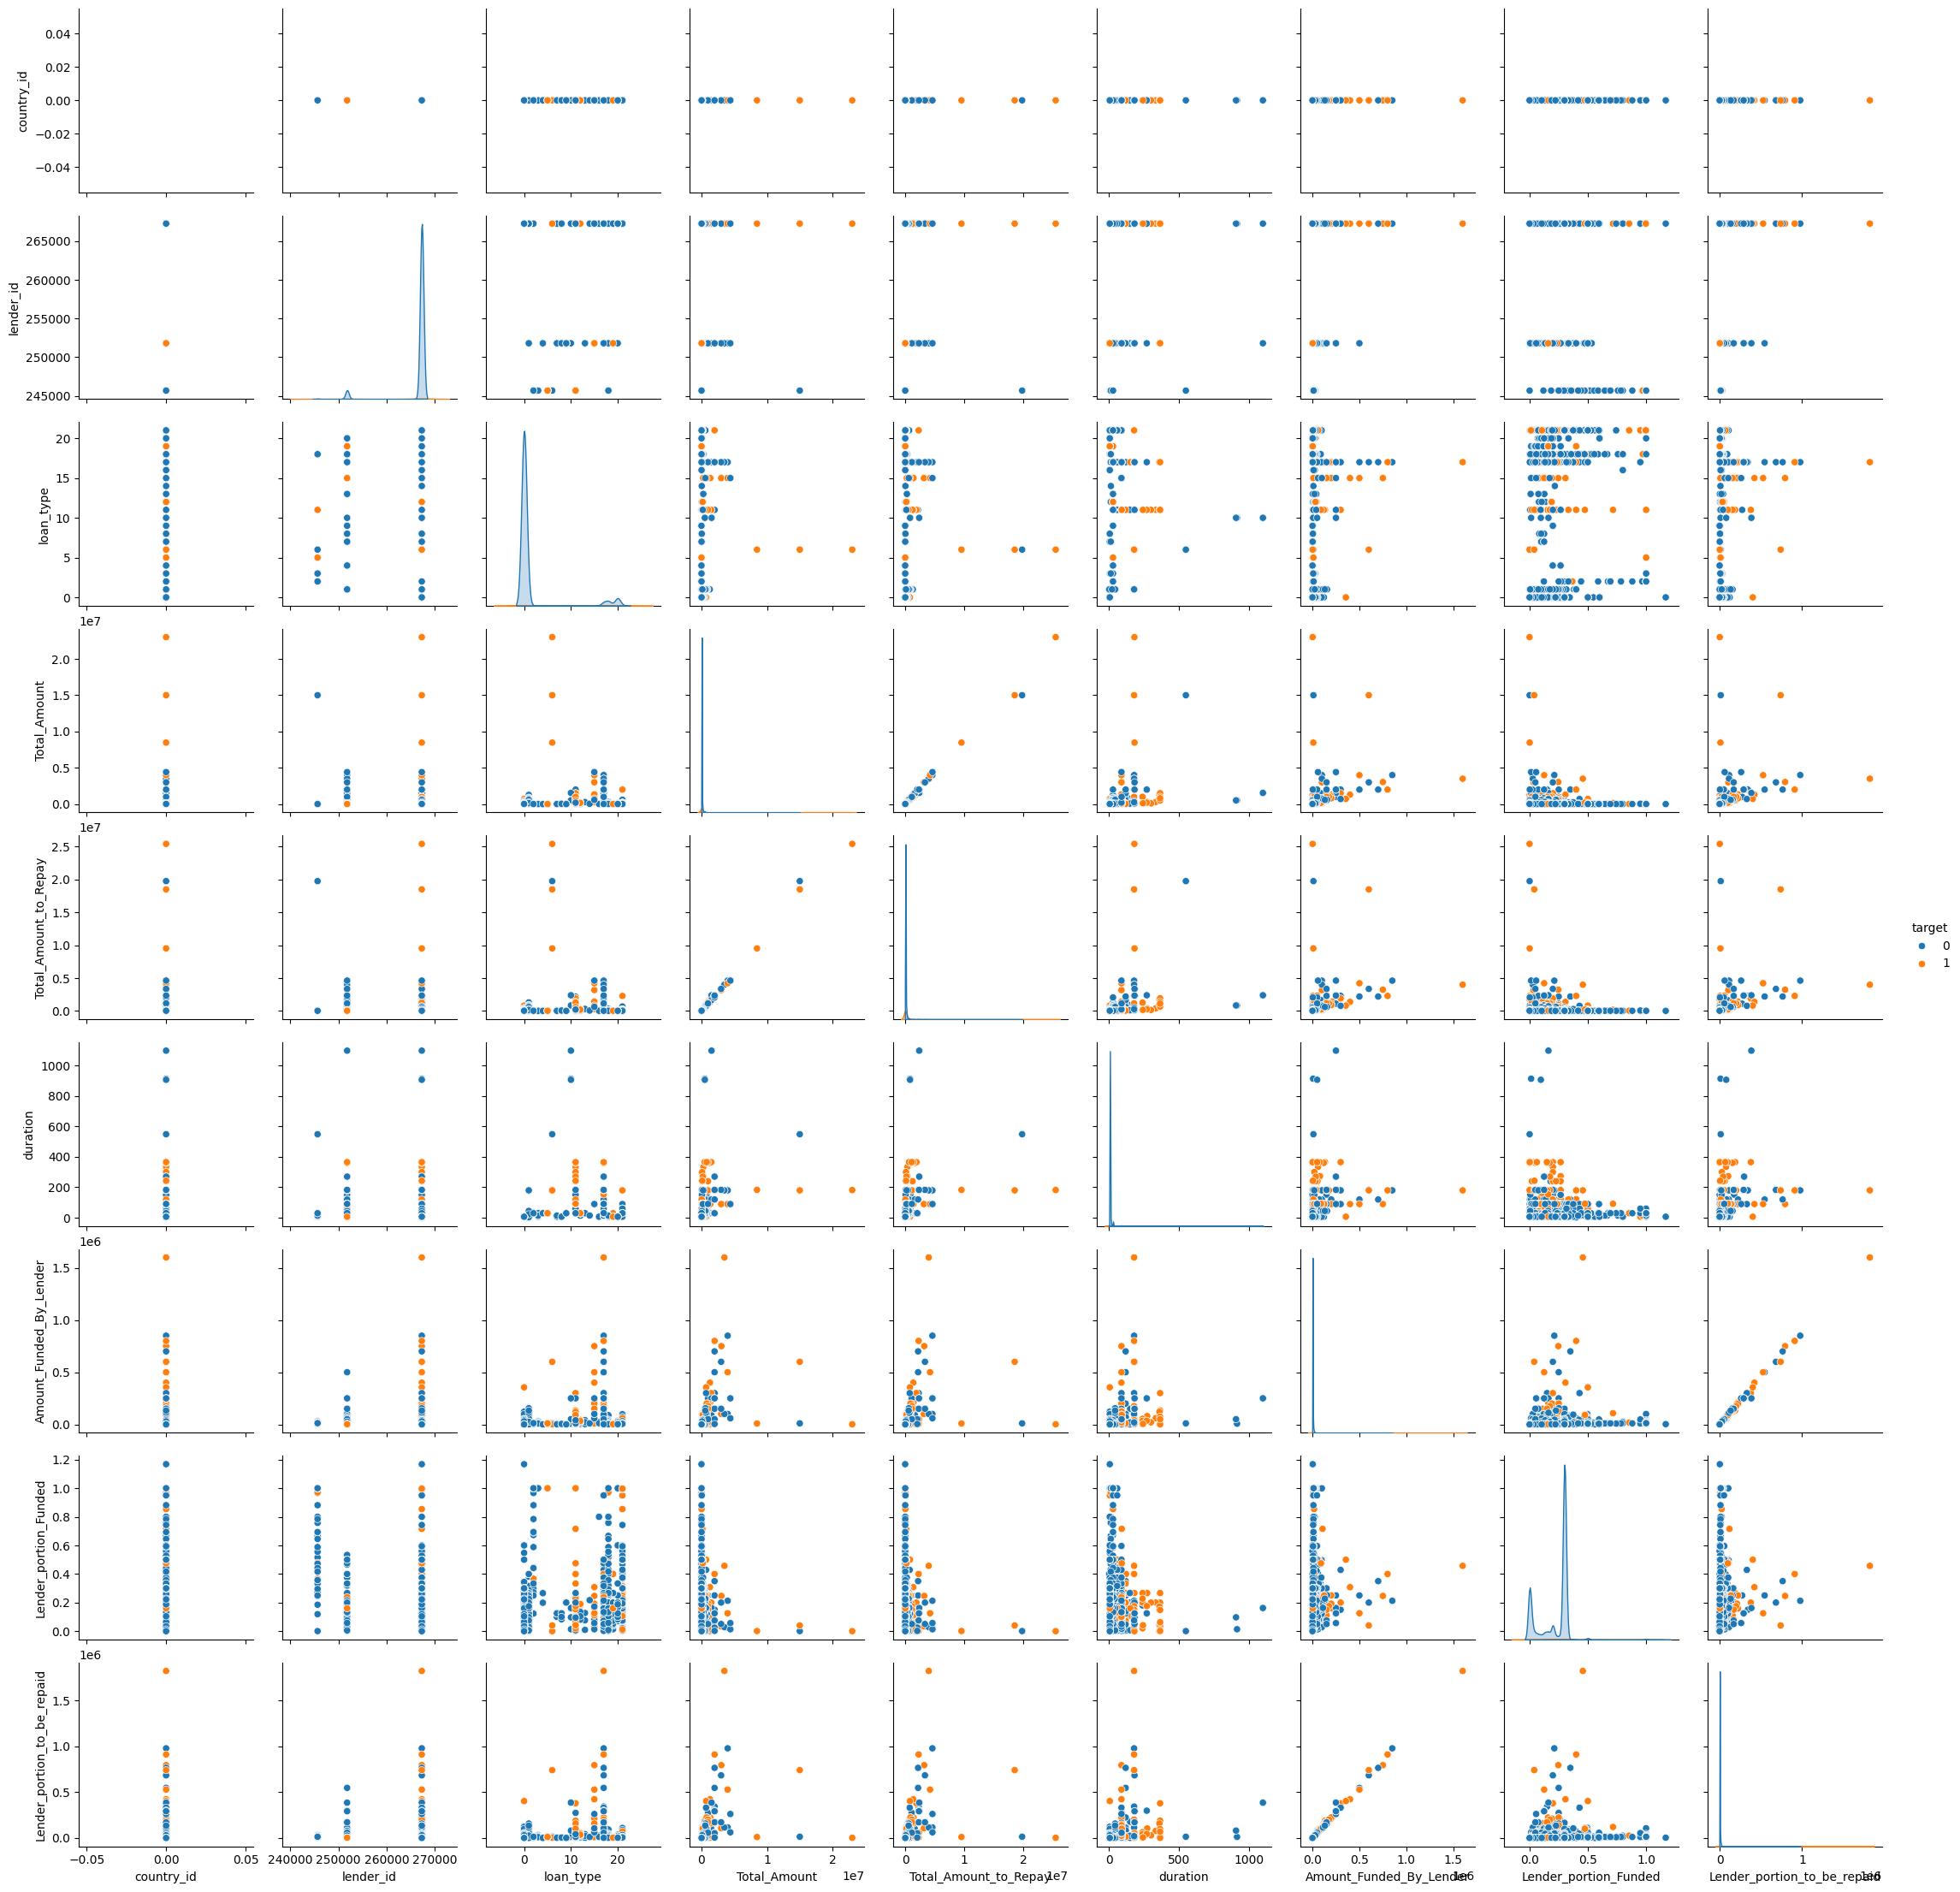

In [21]:
sns.pairplot(pairplot_df.drop(["ID", "tbl_loan_id", "customer_id"],axis=1), hue="target")
plt.show()

#### Hypothesis Testing

In [22]:
def get_sampling_means(df, col, sample_frac=0.2, num_iters=1000):
    data = df[col]
    means = []
    for _ in range(num_iters):
        mean = np.mean(data.sample(frac=sample_frac))
        means.append(mean)

    return means

def get_z_dist(df, col, hue, sample_frac=0.2, num_iters=1000):
    means = get_sampling_means(df, col, sample_frac=sample_frac, num_iters=num_iters)
    mean = np.mean(means)
    std = np.std(means)

    test_group = df[df[hue]==1][col]
    test_mean = test_group.mean()

    return abs(mean-test_mean)/std

##### Duration

In [24]:
sampling_means = get_sampling_means(train_df, "duration", sample_frac=0.02)

In [25]:
np.std(sampling_means)

0.3623266717907003

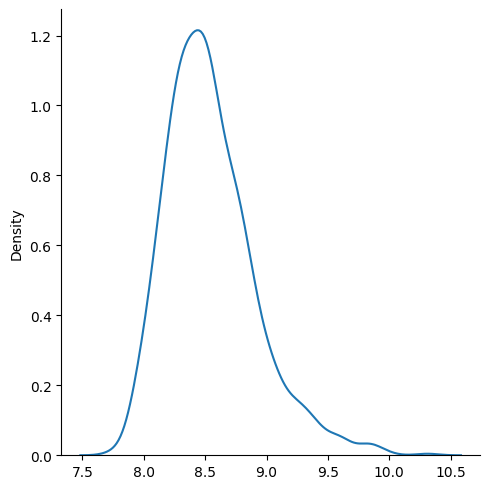

In [26]:
sns.displot(sampling_means, kind="kde")

In [27]:
cols = ['country_id', 'lender_id', 'loan_type',
       'Total_Amount', 'Total_Amount_to_Repay', 'duration',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid']

temp = []

for col in cols:
    z_dist = get_z_dist(pairplot_df, col, "target", sample_frac=0.02)
    temp.append((z_dist, col))

C:\Users\Eli\AppData\Local\Temp\ipykernel_20652\411289042.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return abs(mean-test_mean)/std


In [28]:
sorted(temp)

[(nan, 'country_id'),
 (12.595092621327213, 'Lender_portion_Funded'),
 (23.677401929564443, 'Total_Amount'),
 (24.33013932260318, 'Total_Amount_to_Repay'),
 (28.194948350247447, 'Amount_Funded_By_Lender'),
 (29.20610281835049, 'Lender_portion_to_be_repaid'),
 (46.55680107485831, 'lender_id'),
 (50.81470567509069, 'duration'),
 (55.182650215020146, 'loan_type')]

In [30]:
# stats.ttest_ind(train_df[train])
a = train_df.query("target==1")["Total_Amount_to_Repay"]
b = train_df.query("target==0")["Total_Amount_to_Repay"]

res = stats.ttest_ind(a,b)

In [34]:
res.statistic

22.90556764950311

In [43]:
def ttest(df, col):
    a = df.query("target==1")[col]
    b = df.query("target==0")[col]
    res = stats.ttest_ind(a,b, equal_var=False)

    return res.pvalue, res.statistic

In [45]:
entries = []
for col in cols:
    pvalue, stat = ttest(pairplot_df, col)
    entries.append({"feature": col, "pvalue": pvalue, "statistic":stat})

pd.DataFrame(entries).sort_values("pvalue")

,feature,pvalue,statistic
2,loan_type,1.576113e-163,31.763517
1,lender_id,7.938433e-78,-20.042462
5,duration,1.572732e-36,13.036009
7,Lender_portion_Funded,4.301690e-13,7.322465
8,Lender_portion_to_be_repaid,9.989574e-08,5.358175
6,Amount_Funded_By_Lender,5.631201e-07,5.029463
4,Total_Amount_to_Repay,9.925387e-05,3.904943
3,Total_Amount,1.676862e-04,3.774675
0,country_id,NaN,NaN


In [53]:
# train_df.groupby("customer_id").count()["lender_id"]
train_df["customer_id"].map(train_df.groupby("customer_id").count()["lender_id"])
train_df.shape

(68654, 16)